Uploading all the required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import scipy as sp
import math
from networkx import linalg
import itertools
from itertools import compress
import pandas as pd
import csv

%matplotlib inline

Importing data

In [30]:
routes_data = pd.read_csv('routes.csv')
airport_data = pd.read_csv('airports.csv')

A glimspe of the flights data

In [170]:
routes_data.head()

,Airline_IATA,Airline_ID,Source,Source_ID,Destination,Destination_ID,Number_of_stops,Equipment
0,2B,410,AER,2965,KZN,2990,0,CR2
1,2B,410,ASF,2966,KZN,2990,0,CR2
2,2B,410,ASF,2966,MRV,2962,0,CR2
3,2B,410,CEK,2968,KZN,2990,0,CR2
4,2B,410,CEK,2968,OVB,4078,0,CR2


A glimspe of the aiport data

In [169]:
airport_data.head()

,Airport,Name,City,Country,IATA_code,ICAO_code,Latitude_degrees,Longitude_degrees,Altitude_feet,Timezone_UTC_offset,DST,Timezone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


Create a dictionary of with IATA codes of the airports as the keys and natural numbers as the values.

In [241]:
nodes = list(routes_data['Destination'].unique()) + list(routes_data['Source'].unique())
node_labels = {}
names = {}
k = 0
for item in nodes:
    k = k + 1
    node_labels.update({item:k})
    #names.update({item:airport_data[airport_data['IATA_code'] == item]['Name'][0]})

Geodesic distance/ distance along the great circle arcs

In [118]:
def distance(lat1,lat2, lon1, lon2):
    R = 6371e3 
    # in metres
    phi1 = lat1 * math.pi/180
    # phi, lambda in radians
    phi2 = lat2 * math.pi/180
    delta_phi = (lat2-lat1) * math.pi/180
    delta_lambda = (lon2-lon1) * math.pi/180
    
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1-a));
    d = R * c
    # in metres
    return d/1000.0

Create dictionaries to get the latitudes and longitudes of the airports.

In [ ]:
longitude = {}
longitudes = list(airport_data['Longitude_degrees'])
latitude = {}
latitudes = list(airport_data['Latitude_degrees'])
iata_codes_with_duplicates = list(airport_data['IATA_code'])
for entry in nodes:
    try:
        index = iata_codes_with_duplicates.index(entry)
        longitude.update({entry:longitudes[index]})
        latitude.update({entry:latitudes[index]})
    except ValueError as ve:
        continue
        #print('iata code not found in the airport database')


Define a weighted directed graph using the flight network

In [250]:
G = nx.DiGraph()
for n in range(len(routes_data)):
    try:
        G.add_edge(node_labels[routes_data['Source'][n]],node_labels[routes_data['Destination'][n]], weight = distance(latitude[routes_data['Source'][n]],latitude[routes_data['Destination'][n]],longitude[routes_data['Source'][n]],longitude[routes_data['Destination'][n]]))
    except KeyError as ke:
        continue

Uncomment the following line to get the list of nodes

In [278]:
#list(G.nodes())

Pick any two nodes from the above list to find the shortest path, which corresponds to the shortest flight with respect to distance travelled by the plane

In [172]:
source_airport = 3419
destination_airport = 3604
nx.shortest_path_length(G,source_airport,destination_airport,weight='weight')

2629.1636351327656

Different centrality measures:
1) Degree centrality is equal to the ratio of the number of neighboring vertices/nodes to the total number of vertices/nodes. So, this measure quantifies how strongly an airport plays the role of a hub.
2) Betweenness centrality of an airport is the ratio of the number of shortest paths (flight routes) passing through an airport with fixed source and destination to the total number of shortest paths.
3) Edge betweenennes centrality measures the same quantity as the betweenness centrality but for the edges.

In [167]:
degree_importance_one = nx.degree_centrality(G)
degree_importnace_two = nx.betweenness_centrality(G,weight='weight')
edge_importance = nx.edge_betweenness_centrality(G,weight='weight')

Airport with highest number of nearest/immediate neighbors or edges

In [198]:
vals = list(degree_importance_one.values())
ks = list(degree_importance_one.keys())
position = vals.index(max(vals))
nodekeys = list(node_labels.keys())
airport_data[airport_data['IATA_code'] == nodekeys[position]]

,Airport,Name,City,Country,IATA_code,ICAO_code,Latitude_degrees,Longitude_degrees,Altitude_feet,Timezone_UTC_offset,DST,Timezone,Type,Source
1486,1526,Turin Airport,Torino,Italy,TRN,LIMF,45.200802,7.64963,989,1,E,Europe/Rome,airport,OurAirports


Airport with highest degree centrality

In [200]:
vals = list(degree_importnace_two.values())
ks = list(degree_importnace_two.keys())
position = vals.index(max(vals))
nodekeys = list(node_labels.keys())
airport_data[airport_data['IATA_code'] == nodekeys[position]]

,Airport,Name,City,Country,IATA_code,ICAO_code,Latitude_degrees,Longitude_degrees,Altitude_feet,Timezone_UTC_offset,DST,Timezone,Type,Source
2367,2491,Gobernador Castello Airport,Viedma,Argentina,VDM,SAVV,-40.8692,-63.0004,20,-3,N,America/Argentina/Salta,airport,OurAirports


Flight path with highest degree centrality

In [249]:
vals = list(edge_importance.values())
ks = list(edge_importance.keys())
position = vals.index(max(vals))
nodekeys = list(node_labels.keys())
nodevals = list(node_labels.values())
snode = nodevals.index(list(G.edges.data())[position][0])
dnode = nodevals.index(list(G.edges.data())[position][1])
print(nodekeys[snode],airport_data[airport_data['IATA_code'] == nodekeys[snode]]['Name'])
print(nodekeys[dnode],airport_data[airport_data['IATA_code'] == nodekeys[dnode]]['Name'])

ANC 3574    Ted Stevens Anchorage International Airport
Name: Name, dtype: object
SEA 3377    Seattle Tacoma International Airport
Name: Name, dtype: object


Number of connected components

In [277]:
H = nx.Graph()
for n in range(len(routes_data)):
    try:
        H.add_edge(node_labels[routes_data['Source'][n]],node_labels[routes_data['Destination'][n]], weight = distance(latitude[routes_data['Source'][n]],latitude[routes_data['Destination'][n]],longitude[routes_data['Source'][n]],longitude[routes_data['Destination'][n]]))
    except KeyError as ke:
        continue
        

The number of connected components are not accurate, because we are missing some flight connections due unavailability of iata codes of some airports in the airport database. 

In [191]:
components = list(nx.connected_components(H))
print(len(components))

7


Degree distribution

(array([2884.,  189.,   75.,   45.,   22.,   19.,   12.,    4.,    3.,
           4.]),
 array([  1. ,  25.7,  50.4,  75.1,  99.8, 124.5, 149.2, 173.9, 198.6,
        223.3, 248. ]),
 <a list of 10 Patch objects>)

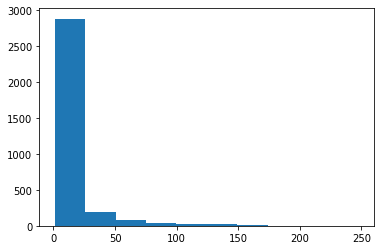

In [279]:
plt.hist([item[1] for item in list(H.degree())])